# TODO
* Evaluer erreurs
* Voir les associations mots->classe
* Voir les ech. qui activent certaines classes
* Éviter les cas d'overlap! (Val 85  Test 190)

In [31]:
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.utils import to_categorical
from keras.regularizers import l2

from sklearn.metrics import classification_report

import classif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
data, num_classes, gen = classif.load_data()

q_labels = ['Démocratie: Comment reprendre le pouvoir?',
'Économie: Comment développer le Québec selon nos priorités?',
'Régions: Comment dynamiser toutes nos communautés?',
'Indépendance: Comment se remettre en marche?',
'Éducation: Comment permettre à tout le monde de réaliser son plein potentiel?',
'Premiers Peuples: Comment construire la solidarité entre nous?',
'Diversité: Comment vivre ensemble sans racisme ni discrimination?',
'Culture: Comment favoriser une création artistique vivante et en assurer l’accès à tous?',
'Santé: Comment prendre soin de tout le monde?',
'Climat: Comment enclencher la transition?']

short_labels = ['Démocratie',
'Économie',
'Régions',
'Indépendance',
'Éducation',
'Premiers Peuples',
'Diversité',
'Culture',
'Santé',
'Climat']

N train, val, test: 3172 317 1799
X_train (3172, 64)
y_train (3172, 10)
X_val (317, 64)
y_val (317, 10)
X_test (1799, 64)
y_test (1799, 10)
Vérifier overlap...
3171
3171
Cas d'overlap: Val 85  Test 190
Bin count train:  [800 161 398  47 819  75  23  78 181 590]
Bin count val:    [86 15 36  4 76 13  3  9 20 55]
Bin count test:   [462  82 249  22 461  39  14  62  97 311]


In [156]:
def build_model(num_classes, l2_reg):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64,), gamma_regularizer=l2(l2_reg)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg)))
    
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    return model


def train(model: Sequential, data, gen=None, verbose=1, epochs=10):
    print('Training...')
    if gen:
        history = model.fit_generator(gen(), 100, epochs=epochs, verbose=verbose,
                                      validation_data=(data['X_val'], data['y_val']))
    else:
        history = model.fit(data['X_train'], data['y_train'],
                            validation_data=(data['X_val'], data['y_val']),
                            verbose=verbose)
    
    return history
    

def test(model: Sequential, data):
    print('Testing...')
    results = model.evaluate(data['X_test'], data['y_test'])
    print('\nLoss: {}  Acc: {}'.format(*results))

In [265]:
# Perform grid search
# best l2_reg = 0.01
reg_list = [0.0, 1e-6, 1e-5]
results = {}

for reg in reg_list:
    print('Trying reg=' + str(reg))
    model = build_model(num_classes, reg)
    history = train(model, data, gen, verbose=0, epochs=40)
    val_acc = np.max(history.history['val_acc'])
    print('Val acc: ' + str(val_acc))
    results[reg] = val_acc

Trying reg=0.0
Training...
Val acc: 0.823343847264
Trying reg=1e-06
Training...
Val acc: 0.832807569662
Trying reg=1e-05
Training...
Val acc: 0.80441640623


In [269]:
# Train best model
model = build_model(num_classes, 1e-6)
history = train(model, data, gen, epochs=200)

Training...
Epoch 1/200
100/100 [==============================] - 6s - loss: 2.0942 - acc: 0.3638 - val_loss: 1.9008 - val_acc: 0.3533
Epoch 2/200
100/100 [==============================] - 1s - loss: 1.5702 - acc: 0.5031 - val_loss: 1.7646 - val_acc: 0.4038
Epoch 3/200
100/100 [==============================] - 1s - loss: 1.3935 - acc: 0.5578 - val_loss: 1.6227 - val_acc: 0.4669
Epoch 4/200
100/100 [==============================] - 1s - loss: 1.3263 - acc: 0.5775 - val_loss: 1.5916 - val_acc: 0.4890
Epoch 5/200
100/100 [==============================] - 1s - loss: 1.1735 - acc: 0.6306 - val_loss: 1.4154 - val_acc: 0.5331
Epoch 6/200
100/100 [==============================] - 1s - loss: 1.1398 - acc: 0.6378 - val_loss: 1.4641 - val_acc: 0.5205
Epoch 7/200
100/100 [==============================] - 1s - loss: 1.0573 - acc: 0.6578 - val_loss: 1.3863 - val_acc: 0.5584
Epoch 8/200
100/100 [==============================] - 1s - loss: 0.9723 - acc: 0.6834 - val_loss: 1.2103 - val_acc: 0.5

100/100 [==============================] - 1s - loss: 0.3524 - acc: 0.8834 - val_loss: 0.3923 - val_acc: 0.8517
Epoch 67/200
100/100 [==============================] - 1s - loss: 0.3730 - acc: 0.8772 - val_loss: 0.3911 - val_acc: 0.8864
Epoch 68/200
100/100 [==============================] - 1s - loss: 0.4015 - acc: 0.8669 - val_loss: 0.4617 - val_acc: 0.8675
Epoch 69/200
100/100 [==============================] - 1s - loss: 0.3792 - acc: 0.8759 - val_loss: 0.3765 - val_acc: 0.8896
Epoch 70/200
100/100 [==============================] - 1s - loss: 0.3503 - acc: 0.8866 - val_loss: 0.4440 - val_acc: 0.8675
Epoch 71/200
100/100 [==============================] - 1s - loss: 0.4086 - acc: 0.8634 - val_loss: 0.4038 - val_acc: 0.8644
Epoch 72/200
100/100 [==============================] - 1s - loss: 0.3881 - acc: 0.8741 - val_loss: 0.3585 - val_acc: 0.8801
Epoch 73/200
100/100 [==============================] - 1s - loss: 0.3437 - acc: 0.8906 - val_loss: 0.4123 - val_acc: 0.8864
Epoch 74/200


100/100 [==============================] - 1s - loss: 0.2833 - acc: 0.9087 - val_loss: 0.2155 - val_acc: 0.9274
Epoch 132/200
100/100 [==============================] - 1s - loss: 0.3081 - acc: 0.9031 - val_loss: 0.2548 - val_acc: 0.9148
Epoch 133/200
100/100 [==============================] - 1s - loss: 0.2955 - acc: 0.9025 - val_loss: 0.2229 - val_acc: 0.9306
Epoch 134/200
100/100 [==============================] - 1s - loss: 0.2740 - acc: 0.9084 - val_loss: 0.2639 - val_acc: 0.9148
Epoch 135/200
100/100 [==============================] - 1s - loss: 0.2952 - acc: 0.8972 - val_loss: 0.2752 - val_acc: 0.9274
Epoch 136/200
100/100 [==============================] - 1s - loss: 0.3180 - acc: 0.8925 - val_loss: 0.2256 - val_acc: 0.9274
Epoch 137/200
100/100 [==============================] - 1s - loss: 0.2524 - acc: 0.9194 - val_loss: 0.2039 - val_acc: 0.9495
Epoch 138/200
100/100 [==============================] - 1s - loss: 0.2645 - acc: 0.9131 - val_loss: 0.2329 - val_acc: 0.9338
Epoch 

100/100 [==============================] - 1s - loss: 0.2266 - acc: 0.9253 - val_loss: 0.1602 - val_acc: 0.9621
Epoch 197/200
100/100 [==============================] - 1s - loss: 0.2241 - acc: 0.9272 - val_loss: 0.1646 - val_acc: 0.9653
Epoch 198/200
100/100 [==============================] - 1s - loss: 0.2395 - acc: 0.9172 - val_loss: 0.1780 - val_acc: 0.9558
Epoch 199/200
100/100 [==============================] - 1s - loss: 0.2401 - acc: 0.9262 - val_loss: 0.1720 - val_acc: 0.9464
Epoch 200/200
100/100 [==============================] - 1s - loss: 0.2233 - acc: 0.9291 - val_loss: 0.1873 - val_acc: 0.9527


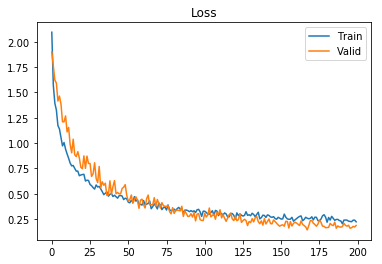

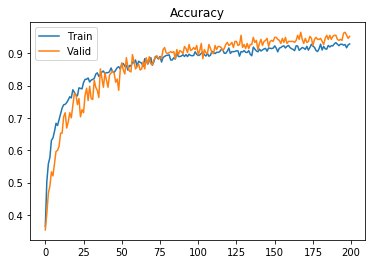

In [270]:
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Valid')
plt.legend()
plt.show()

In [271]:
y_pred = model.predict(data['X_test'])
y_pred = to_categorical(np.argmax(y_pred, axis=1), num_classes)
test_acc = np.mean(y_pred == data['y_test'])
print('Test accuracy: ' + str(test_acc))
print(classification_report(data['y_test'], y_pred))

Test accuracy: 0.986992773763
             precision    recall  f1-score   support

          0       0.99      0.92      0.95       483
          1       0.92      0.95      0.93        83
          2       0.92      0.94      0.93       232
          3       0.93      0.93      0.93        29
          4       0.97      0.92      0.95       461
          5       0.97      0.94      0.96        35
          6       0.28      1.00      0.44        14
          7       0.92      1.00      0.96        44
          8       0.81      0.95      0.87        94
          9       0.98      0.95      0.97       324

avg / total       0.95      0.93      0.94      1799



In [92]:
import word2vec
import matplotlib.pyplot as plt
embedder = word2vec.Embedder()

Embedding answers...


In [138]:
def plot_pred(y_pred):
    ind = np.arange(num_classes)  # the x locations for the groups
    width = 0.35                  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, y_pred.ravel())

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Probabilité')
    ax.set_title('Sujet')
    ax.set_xticks(ind)
    ax.set_xticklabels(short_labels, rotation=70)

    plt.show()

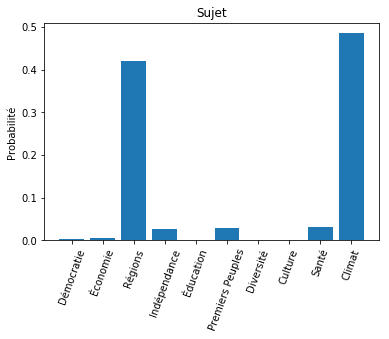

In [305]:
test_ans = embedder.embed_phrase("éolienne")
somme = np.sum(np.abs(test_ans))
if somme < 1e-3:
    print('Mots inconnus. Somme: ' + str(somme))
y_pred = model.predict(test_ans[None, :])
plot_pred(y_pred)